## Climate Change Belief Analysis
### By Team_JS_2_EDSA

# 1: Introduction

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

This predict layout as follows:

    1. Introduction
    2. Import libraries and load data
    3. Data pre-processing
    4. Exploratory Data Analysis
    5. Building models
    6. Best model
    7. Conclusion
    8. Submission

# 2: Import libraries and load data

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.utils import resample

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import f1_score
from sklearn import metrics

## The data

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018!

In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes: 2, 1, 0, -1

**Class Description:**

- 2 News: the tweet links to factual news about climate change

- 1 Pro: the tweet supports the belief of man-made climate change

- 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change

- -1 Anti: the tweet does not believe in man-made climate change Variable definitions

**Columns:**

- sentiment: Sentiment of tweet

- message: Tweet body

- tweetid: Twitter unique id

In [2]:
#Loading data and view first few rows
train = pd.read_csv("train.csv")
test = pd.read_csv("test_with_no_labels.csv")

In [3]:
train

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954
...,...,...,...
15814,1,RT @ezlusztig: They took down the material on ...,22001
15815,2,RT @washingtonpost: How climate change could b...,17856
15816,0,notiven: RT: nytimesworld :What does Trump act...,384248
15817,-1,RT @sara8smiles: Hey liberals the climate chan...,819732


In [4]:
test

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928
...,...,...
10541,"RT @BrittanyBohrer: Brb, writing a poem about ...",895714
10542,2016: the year climate change came home: Durin...,875167
10543,RT @loop_vanuatu: Pacific countries positive a...,78329
10544,"RT @xanria_00018: You’re so hot, you must be t...",867455


# 3: Data pre-processing

## 3.1 - Let's do some data cleaning

Function for cleaning the data:

* Remove punctuations 
* Remove stop words
* Lemmitazation 

In [5]:
#Cleaning all tweets by removing url-links, punctuation, digits, stopwords and Lemmatizing all the words.
def clean_tweets(message):

    # change all words into lower case
    message = message.lower()

    # replace all url-links with url-web
    url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    web = 'url-web'
    message = re.sub(url, web, message)

    # removing all punctuation and digits
    message = re.sub(r'[-]',' ',message)
    message = re.sub(r'[^\w\s]','',message)
    message = re.sub('[0-9]+', '', message)

    message = re.sub("â|ã", " ", message)  # removes strange character    
    message = re.sub("\\s+", " ", message)  # fills white spaces
    message = message.lstrip()  # removes whitespaces before string
    message = message.rstrip()  # removes whitespaces after string 
    

    # lemmatizing all words
    message = message.lower()
    lemmatizer = WordNetLemmatizer()
    message = [lemmatizer.lemmatize(token) for token in message.split(" ")]
    message = [lemmatizer.lemmatize(token, "v") for token in message]
    message = " ".join(message)

    return message

In [6]:
#Apply the clean function to our train and test data
train['message_clean']=train['message'].apply(clean_tweets)

test['message_clean']=test['message'].apply(clean_tweets)

In [9]:
#Data after clean: Train
train.head()

,sentiment,message,tweetid,message_clean
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,it not like we lack evidence of anthropogenic ...
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researcher say we have three year ...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wire wa a pivotal year in the war...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas it and a racist sexist clim...


In [10]:
#Data after clean: Test
test.head()

,message,tweetid,message_clean
0,Europe will now be looking to China to make su...,169760,europe will now be look to china to make sure ...
1,Combine this with the polling of staffers re c...,35326,combine this with the poll of staffer re clima...
2,"The scary, unimpeachable evidence that climate...",224985,the scary unimpeachable evidence that climate ...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,karoli morgfair osborneink dailykos putin get ...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,rt fakewillmoore female orgasm cause global wa...


## 3.2 - Let's see if there is a imbalance in the data

In [6]:
#Count of data entries for different sentiments
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

C:\Users\Wilbul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

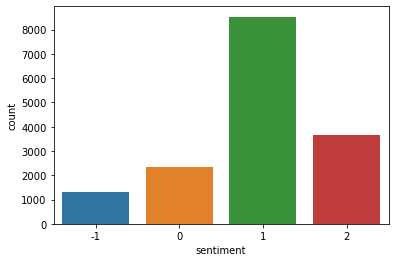

In [8]:
#View class distribution to confirm balance/imbalance
sns.countplot(train['sentiment'])

## Balancing the data

There is a different ways of balancing data:

- 1: Resampling
- 2: SMOTE

In [9]:
#Applying each sentiment to their own data frame
news = train[train['sentiment'] == 2]
pro = train[train['sentiment'] == 1]
neutral = train[train['sentiment'] == 0]
anti = train[train['sentiment'] == -1]

In [10]:
#Applying the resampling method to the data
news_upsampled = resample(news, replace=True, n_samples=len(pro), random_state=27)
neutral_upsampled = resample(neutral, replace=True, n_samples=len(pro), random_state=27)
anti_upsampled = resample(anti, replace=True, n_samples=len(pro), random_state=27)

## Combine majority and new upsampled minority

In [11]:
#New upsampled train dataframe
df_upsampled = pd.concat([pro, news_upsampled, neutral_upsampled, anti_upsampled])

In [12]:
df_upsampled.sentiment.value_counts()

-1    8530
 2    8530
 1    8530
 0    8530
Name: sentiment, dtype: int64

C:\Users\Wilbul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

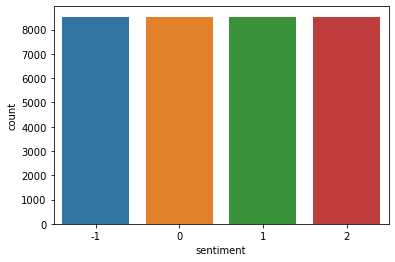

In [15]:
sns.countplot(df_upsampled['sentiment'])

In [16]:
df_upsampled

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954
5,1,Worth a read whether you do or don't believe i...,425577
...,...,...,...
5422,-1,RT @worldnetdaily: Sorry global warming liars....,857394
11148,-1,RT @charlesadler: #Trudeau gov now admitting l...,509562
11428,-1,That would be a natural storm and of course po...,158073
1341,-1,RT @TheFoundingSon: NOAA scientists manipulate...,905959


# 4: Exploratory Data Analysis

- Make use of seaborn, wordcloud and matplotlib

## 4.1: Extract Hashtags

## 4.2: Extract Frequently used words

## 4.3: Named entity extraction 

## 4.4: Create graphs

# 5: Modeling

Here we can decide to use one of two dataframes:

- 1: Normal clean train dataframe(train)
- 2: Balanced clean train dataframe(df_upsampled)

### Splitting out the X variable from the target

In [17]:
#Splitting our train clean train data and training it
X = train['message_clean']
y = train['sentiment'] 

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

### Turning text into something your model can read, we will make use of Pipeline package to vectorize and run our models

Models:
- 1: Linear Support Vector Classifier
- 2: ......
- 3: ......
- 4: .....


In [18]:
#Pipeline to for vect and training
Model_1_pipe = Pipeline([
                        ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))), 
                        ('classification', LinearSVC()) 
                        ])

#Fitting our Linear SVC model
Model_1_pipe.fit(X, y)


### After fitting our model now we predict and evaluate our model

In [ ]:
#Prediting our findings of our model and see how accurate it is.
y_pred_lsvc = Model_1_pipe.predict(X_test)

In [ ]:
print("Model: Linear SVC Metrics")
print(metrics.classification_report(y_test, y_pred_lsvc))

### As we can see our model predicts very accurate on our train test and split data with a +95%, now we will go and use the model on our unseen test data

# 6: Use best model on our test/real word data

In [ ]:
#Using our pipeline best model to predict our findings
test['sentiment'] = Main_final.predict(test['message_clean'])

In [ ]:
#Viewing our new data for sentiment in test dataframe
test.head()

# 7: Conclusion

# 8: Submission
 Creating an output csv for submission

In [26]:
#Submission in our kaggle format
submission = test[['tweetid', 'sentiment']]
submission.to_csv('LSVC.csv',index=False)